# 데이터 전처리

@author 컴퓨터과학과 황승현

## 2024년 New 전처리 행동강령

1. 데이터 drop은 최대한 줄인다.
1. 바이올린 플롯 등으로 이상값을 찾아 없앤다.
1. 결측값 대치는 변수 하나하나 고민해서 한다.

## 전처리 절차

1. 종속변수 AS1_OP 가공
    - AS1_DT
    - AS1_MT

2. 데이터셋 분리
    - 여성(폐경 전) (AS1_PMYN_C: 1)
    - 여성(폐경 후) (AS1_PMYN_C: 2)

3. var_to_use활용
    1. 질환유무, 약물력 변수 가공
    2. 가족력, 가족과의 관계 변수 가공
        - 부, 모, 형제자매, 기타 -> 부모, 형제자매, 기타, 해당없음

6. 이상치 탐지 후 제거: 바이올린 플롯

7. 결측값 대치
    - 전처리 행동강령

-----

독립변수는 4가지로 분류 (binary, cath0, cath1, cnt)

- binary: 범주형(binary) 변수
-  catH0: 계층 없는 범주형(>03) 변수, 벡터화(cb-encoding)
-  catH1: 계층 있는 범주형 변수
-    cnt: 연속형 변수, 정규화

## 준비

- 라이브러리 불러오기
- 데이터셋, 사용할 변수 불러오기

In [41]:
# 라이브러리 불러오기
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer

In [42]:
# 데이터셋 불러오기
# dataset = pd.read_csv("dataset/Dataset_OP_230316_raw.csv", index_col=0, na_values=[77777, 99999, '#NULL!', ' ']) # 사용안함
# dataset = pd.read_csv("dataset/Dataset_OP_230330_raw.csv", index_col=0, na_values=[77777, 99999, '#NULL!', ' ']) # 사용안함
# dataset = pd.read_csv("dataset/Dataset_OP_230417_raw.csv", index_col=0, na_values=[77777, 99999, '#NULL!', ' ']) # 사용안함
# dataset = pd.read_csv("dataset/Dataset_OP_230424_raw.csv", index_col=0, na_values=[77777, 99999, '#NULL!', ' ']) # 사용안함
dataset = pd.read_csv("dataset/Dataset_OP_230614_raw.csv", index_col=0, na_values=[77777, 99999, '#NULL!', ' '], low_memory=False)
dataset.head()

,AS1_SEX,AS1_AGE,AS1_FAMNUM,AS1_HAND,AS1_SEAS,AS1_MARRYA,AS1_MARRYAETC,AS1_RELIG,AS1_RELIGETC,AS1_RELIGPRT,...,AS1_INSM.1,AS1_SLPHRD.1,AS1_SLPAMSF.1,AS1_ICOFF_1,AS1_ICOFF_2,AS1_W098.1,AS1_MNSAG.2,AS1_BRSTF,AS1_BRSTC,AS1_EGFR
DIST_ID,,,,,,,,,,,,,,,,,,,,,
NIH2307795046,1,53,4.0,1.0,3.0,2.0,NaN,3.0,NaN,1.0,...,1.0,1.0,2.0,2,2,0.225000,NaN,NaN,NaN,81.027088
NIH2307713334,2,44,2.0,1.0,2.0,2.0,NaN,4.0,NaN,NaN,...,1.0,1.0,2.0,3,2,0.578571,13.0,NaN,NaN,223.651123
NIH2307455306,2,43,6.0,1.0,2.0,2.0,NaN,3.0,NaN,1.0,...,1.0,1.0,1.0,1,1,0.000000,20.0,2.0,3.0,225.227717
NIH2307778268,1,61,4.0,1.0,4.0,2.0,NaN,3.0,NaN,1.0,...,1.0,1.0,2.0,2,2,0.225000,NaN,NaN,NaN,134.847877
NIH2307137554,2,64,4.0,1.0,1.0,2.0,NaN,3.0,NaN,1.0,...,1.0,1.0,2.0,4,2,0.000000,17.0,2.0,2.0,194.337250


In [43]:
# 특성별로 분류
# var_to_use = pd.read_csv("dataset/var_to_use_2023-03-30T2240I.csv")
# var_to_use = pd.read_csv("dataset/var_to_use_2023-04-21T1258I.csv")
# var_to_use = pd.read_csv("dataset/var_to_use_2023-04-24T1830I.csv")
# var_to_use = pd.read_csv("dataset/var_to_use_2023-04-28T1610I.csv")
var_to_use = pd.read_csv("dataset/var_to_use_2023-06-13T1650I.csv")
var_to_use


,binary,cath0,cath1,cnt,dependent
0,AS1_SEX,AS1_EDUA,AS1_INCOME,AS1_AGE,AS1_DT
1,AS1_HT,AS1_DRINK,AS1_PHYSTB,AS1_TOTALC,AS1_MT
2,AS1_DM,AS1_SMOKEA,AS1_PHYSIT,AS1_PMAG_C,NaN
3,AS1_AL,AS1_FMOSREL_N,AS1_PHYACTL,AS1_MNSAG,NaN
4,AS1_MI,AS1_FMOSREL_O,AS1_PHYACTM,AS1_CHILD_P,NaN
...,...,...,...,...,...
70,NaN,NaN,NaN,AS1_BPSIT1RS,NaN
71,NaN,NaN,NaN,AS1_BPSIT1SYS,NaN
72,NaN,NaN,NaN,AS1_BPSIT1LD,NaN
73,NaN,NaN,NaN,AS1_BPSIT1RD,NaN


## 데이터 가공

- 기존 데이터로 새로운 데이터 만들기
- if 문 쓰면 안됨!
    - The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
- np.where 사용할 것!

### 종속변수 결측값 drop X

In [44]:
# 종속변수의 결측값이 있으면 drop
# dataset.dropna(subset=['AS1_DT', 'AS1_MT'], inplace=True)
test = dataset.dropna(subset=['AS1_DT', 'AS1_MT'])

# 폐경여부 없는 사람 drop
# dataset.dropna(subset = ['AS1_PMYN_C'], inplace=True)

# 남성(1) drop, 여성(2)만 가져옴
dataset = dataset[dataset['AS1_SEX'] == 2]
test = test[test['AS1_SEX'] == 2]

# 새로운 종속변수 만들기 OP: 골다공증 여부
dataset['OP'] = np.where((dataset['AS1_DT'] <= -2.5) | (dataset['AS1_MT'] <= -2.5), 1, 0)
test['OP'] = np.where((test['AS1_DT'] <= -2.5) | (test['AS1_MT'] <= -2.5), 1, 0)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4798 entries, NIH2307713334 to NIH2307534318
Columns: 839 entries, AS1_SEX to OP
dtypes: float64(795), int32(1), int64(38), object(5)
memory usage: 30.7+ MB


In [45]:
print(len(test['OP']))
print(test['OP'].value_counts())

print(len(dataset['OP']))
print(dataset['OP'].value_counts())


4680
OP
0    3785
1     895
Name: count, dtype: int64
4798
OP
0    3874
1     924
Name: count, dtype: int64


종속변수의 결측값이 있으면 drop하는 것 비교

`dataset.dropna(subset=['AS1_DT', 'AS1_MT'], inplace=True)`

drop 함
```
4680
0    3785
1     895
Name: OP, dtype: int64
```

drop 안 함
```
4798
0    3874
1     924
Name: OP, dtype: int64
```

drop을 하지 않고 118명 더 확보


In [46]:
dataset['AS1_PMYN_C'].value_counts()

AS1_PMYN_C
2.0    3032
1.0    1738
Name: count, dtype: int64

### 각종 질환 가공

- 질환 유무
    - 각종 종양 유무 (AS1_TOTCA1)
- 약물력
- 가족력

In [47]:
# 질환유무 가공
disease_list = np.array(['HT', 'DM', 'AL', 'MI', 'TH', # 질환 목록
                         'CH', 'CD', 'LP', 'AS', 'CL',
                         'KD', 'CV', 'GT' ]) # UL, PV, HN, TOTCA1 제외

dataset['AS1_ARRM'] = np.where((dataset['AS1_JOAR'] == 2) | (dataset['AS1_JORM'] == 2) | (dataset['AS1_TRTAR'] == 2), 1, 0) # 관절염은 조건 3가지 만족하면 1 아니면 0

for x in disease_list:
    dataset['AS1_'+x] = np.where((dataset['AS1_PD'+x] == 2) | (dataset['AS1_TRT'+x] == 2), 1, 0) # 질환여부 정의. AS1_PDㅇㅇ 또는 AS1_TRTㅇㅇ 이 2이면 1 아니면 0


In [48]:
# 약물력 가공
drug_list = np.array(['ST', 'CP', 'INS', 'HT', 'AR', 
                      'TH', 'FH', 'OS', 'STK', 'AS',
                      'LP', 'SP', 'SL'])  # UL, DM, CP, HP 제외 SP, SL 추가
for x in drug_list:
    dataset['AS1_DR'+x] = np.where((dataset['AS1_DRUG'+x] == 2) | (dataset['AS1_DRUG'+x+'CU'] == 2), 1, 0)


In [49]:
# 가족력 가공
# N: 가족력 없음, P: parent 부모, S: sibling 형제자매, O: other 기타
# N: REL1A~4A까지 99999
# P: REL1A~4A중 1, 2 있을 때
# S: REL1A~4A중 3 있을 때
# O: REL1A~4A중 4 있을 때

# disease_dict = {
#     'HT': 4, 'DM': 4, 'CVA': 3, 'HE': 2, 'OS': 2,
#     'CVB': 2, 'CD': 2, 'PV': 2, 'LP': 2, 'GT': 2,'CH': 1
# }
disease_dict = { 'OS': 2 }

for disease, num_family in disease_dict.items():
    dataset[f'AS1_FM{disease}REL_N'] = np.all(dataset[[f'AS1_FM{disease}REL{i}A' for i in range(1, num_family+1)]] == 99999, axis=1).astype(int)
    dataset[f'AS1_FM{disease}REL_P'] = np.any(dataset[[f'AS1_FM{disease}REL{i}A' for i in range(1, num_family+1)]] <= 2, axis=1).astype(int)
    dataset[f'AS1_FM{disease}REL_S'] = np.any(dataset[[f'AS1_FM{disease}REL{i}A' for i in range(1, num_family+1)]] == 3, axis=1).astype(int)
    dataset[f'AS1_FM{disease}REL_O'] = np.any(dataset[[f'AS1_FM{disease}REL{i}A' for i in range(1, num_family+1)]] == 4, axis=1).astype(int)

In [50]:
dataset[[f'AS1_FM{disease}REL_{family}' for disease in disease_dict.keys() for family in ['N', 'P', 'S', 'O']]]

,AS1_FMOSREL_N,AS1_FMOSREL_P,AS1_FMOSREL_S,AS1_FMOSREL_O
DIST_ID,,,,
NIH2307713334,0,0,0,0
NIH2307455306,0,0,0,0
NIH2307137554,0,0,0,0
NIH2307649667,0,0,0,0
NIH2307899915,0,1,0,0
...,...,...,...,...
NIH2307591031,0,0,0,0
NIH2307808901,0,0,0,0
NIH2307930134,0,0,0,0


### 여성력 가공

- ~~질환~~
- 약물
- 기타 수술 (AS1_OBGYOP)
    - 자궁경부암수술/ 자궁암수술/ 자궁내막암/자궁경부암,나팔관제거수술/ 만 1 나머지는 0

In [51]:
# 여성력 가공
# 남성 데이터 셋을 제거하여 필요없음

# 남자일 경우: 0 여자일 경우: 그대로
# for x in ['CP', 'FH']:
#     dataset['AS1_DR'+x] = np.where(dataset['AS1_SEX'] == '1',
#                                    0,
#                                    np.where((dataset['AS1_DRUG'+x] == 2) | (dataset['AS1_DRUG'+x+'CU'] == 2), 2, 1))

for x in ['CP', 'FH']:
    dataset['AS1_DR'+x] = np.where((dataset['AS1_DRUG'+x] == 2) | (dataset['AS1_DRUG'+x+'CU'] == 2), 1, 0)


# women = np.array(['AS1_PREG', 'AS1_HYST', 'AS1_HYSTOVARYW', 'AS1_OVARYW',
#                   'AS1_OBGYOP', 'AS1_BRCA', 'AS1_DRCP', 'AS1_DRFH'])
#
# for x in women:
#     dataset[x] = np.where((dataset['AS1_SEX'] == 1), 0, dataset[x])

### 앉은 자세 혈압
- AS1_BPSit1SYS
    - AS1_BPSit1LS, AS1_BPSit1RS 변수 중 높은 값
- AS1_BPSit1DIA
    - AS1_BPSit1LD,  AS1_BPSit1RD  변수 중 높은 값

In [52]:
dataset['AS1_BPSIT1SYS'] = np.where(dataset['AS1_BPSIT1LS'] > dataset['AS1_BPSIT1RS'], dataset['AS1_BPSIT1LS'], dataset['AS1_BPSIT1RS'])

dataset['AS1_BPSIT1DIA'] = np.where(dataset['AS1_BPSIT1LD'] > dataset['AS1_BPSIT1RD'], dataset['AS1_BPSIT1LD'], dataset['AS1_BPSIT1RD'])

### 타입 별 분리

In [53]:
# var_to_use의 각 열 가져옴

raw_binary = dataset.reindex(columns=(var_to_use['binary'].dropna()))
raw_cath0 = dataset.reindex(columns=(var_to_use['cath0'].dropna()))
raw_cath1 = dataset.reindex(columns=(var_to_use['cath1'].dropna()))
raw_cnt = dataset.reindex(columns=(var_to_use['cnt'].dropna()))
raw_label = dataset.reindex(columns=(var_to_use['dependent'].dropna()))

In [54]:
# null인 행이 있다.... 코드북과 데이터셋이 불일치한다.
dataframes = {
    "raw_binary": raw_binary,
    "raw_cath0": raw_cath0,
    "raw_cath1": raw_cath1,
    "raw_cnt": raw_cnt
}

for name, df in dataframes.items():
    null_cell = pd.Series(index=df.columns)
    null_cell = null_cell[df.isnull().sum() >= len(dataset)]  # 코드북에 없는 데이터 리스트
    print(f"{name}에서 발견된 누락 데이터 열:")
    print(null_cell)

raw_binary에서 발견된 누락 데이터 열:
Series([], dtype: float64)
raw_cath0에서 발견된 누락 데이터 열:
Series([], dtype: float64)
raw_cath1에서 발견된 누락 데이터 열:
Series([], dtype: float64)
raw_cnt에서 발견된 누락 데이터 열:
Series([], dtype: float64)


In [55]:
# dataset['OP']는 문제 없음
print(raw_label.isnull().sum())
print(dataset['OP'].isnull().sum())

dependent
AS1_DT    77
AS1_MT    41
dtype: int64
0


## 이상치 탐지, 결측값 대치

아주 썩어빠진 마인드
> - 일부 데이터의 많은 결측값
>   - 77777 -> 0
>     - AS1_TOTALC
>     - AS1_HVSMAM
>   - 99999 -> ?
>     - AS1_FMOSREL1A
>     - AS1_CA_U
>     - AS1_NA_U
>     - AS1_K_U
>
> - binary, cath0, cath1: 각 칼럼의 최빈값으로 대치
> - cnt: 평균값으로 대치



In [59]:
 # AS1_BRCA 유방암 수술 여부.. 수술 안 함으로 변경
print(len(raw_binary['AS1_BRCA']))
print(raw_binary['AS1_BRCA'].isnull().sum())
raw_binary['AS1_BRCA'].value_counts()

4798
257


AS1_BRCA
1.0    4506
2.0      35
Name: count, dtype: int64

In [62]:
raw_binary['AS1_BRCA'] = raw_binary['AS1_BRCA'].fillna(1.0)
print(raw_binary['AS1_BRCA'].isnull().sum())
raw_binary['AS1_BRCA'].value_counts()

0


AS1_BRCA
1.0    4763
2.0      35
Name: count, dtype: int64

In [35]:
raw_binary = raw_binary.fillna(raw_binary.mode().iloc[0])
raw_cath0 = raw_cath0.fillna(raw_cath0.mode().iloc[0])
raw_cath1 = raw_cath1.fillna(raw_cath1.mode().iloc[0])
raw_cnt = raw_cnt.fillna(raw_cnt.mean())

binary = raw_binary.astype('float')
cath1 = raw_cath1.astype('float')
cath0 = raw_cath0.astype('float')
cnt = raw_cnt.astype('float')

### 바이올린 플롯

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

<Figure size 640x480 with 0 Axes>

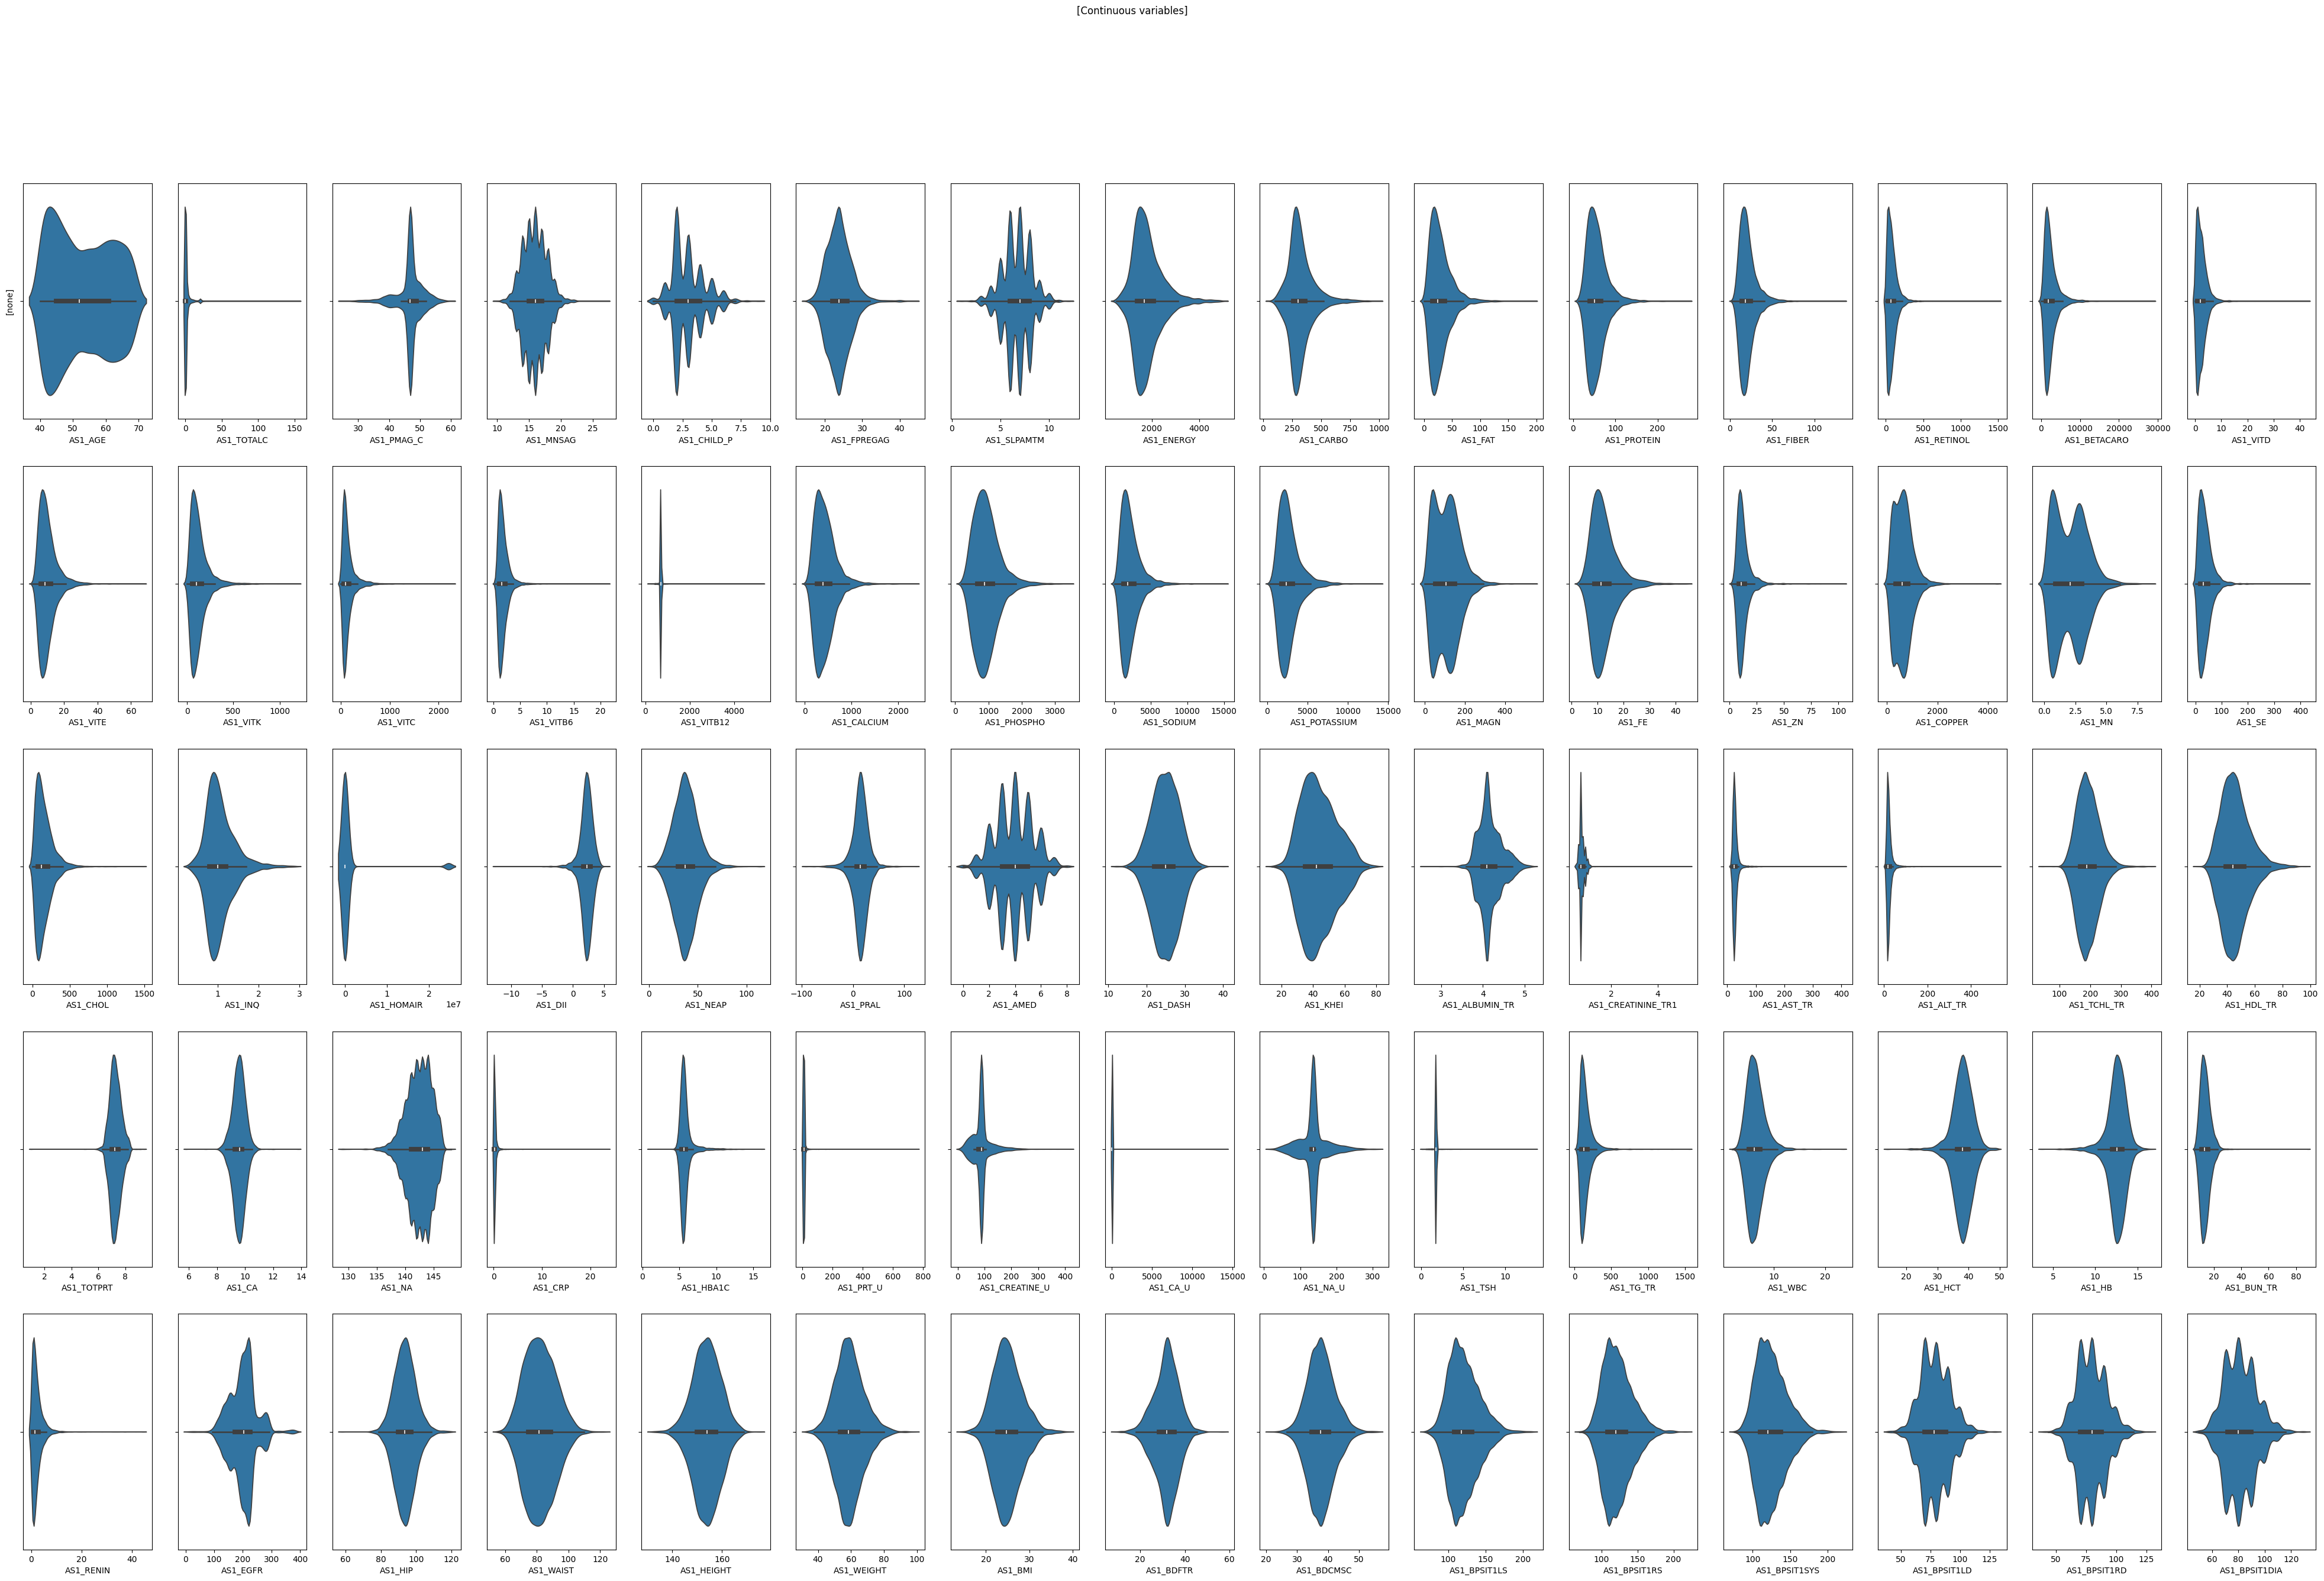

In [36]:
plt.tight_layout()
# 75개의 바이올린 플롯을 위한 빈 Figure와 Axes 객체 생성
fig, axes = plt.subplots(nrows=5, ncols=15, figsize=(50, 30))

# 칼럼 인덱스 카운터
i = 0

# 모든 칼럼 순회
for col in cnt.columns:
    # 5행 15열 Axes 객체 배열에 순서대로 바이올린 플롯 그리기
    sns.violinplot(data=cnt, x=col, ax=axes[i // 15][i % 15])
    i += 1

# 그래프 제목 설정
fig.suptitle("[Continuous variables]")

# x축 라벨 설정
for ax in axes.flat:
    ax.set_xlabel(ax.get_xlabel(), rotation=0)

# y축 라벨 설정
axes[0, 0].set_ylabel("[none]")

# plt.show()를 사용하면 그래프가 즉시 뜨고 코드 실행이 멈춥니다.
# plt.savefig("[파일 경로]")를 사용하면 지정된 경로에 그래프 파일을 저장합니다.
plt.savefig("./vp.png")

## 데이터셋에 유전체 붙이기

In [143]:
# 유전체 SNP 매칭
gen_dict = {3335: "SNP_A-2181021",
            214246: "SNP_A-1809518",
            262783: "SNP_A-2130710",
            35799: "SNP_A-2263153",
            154529: "SNP_A-2310995",
            118171: "SNP_A-1922415",
            182907: "SNP_A-2266073",
            122732: "SNP_A-1984271",
            283204: "SNP_A-2218697",
            217552: "SNP_A-1850320",
            335062: "SNP_A-4262878",
            335032: "SNP_A-4299800",
            335031: "SNP_A-2242511"
            }

In [144]:
# 유전체 데이터프레임 만들기
df_all_gen = pd.DataFrame()

for v in gen_dict.values():
    temp = pd.read_csv(f"./dataset/genome/result_{v}.csv", index_col=1, low_memory=False).dropna()
    temp.rename(columns={"SNP": v}, inplace=True)
    df_all_gen = pd.concat([df_all_gen, temp[v]], axis=1)

df_all_gen.head()

,SNP_A-2181021,SNP_A-1809518,SNP_A-2130710,SNP_A-2263153,SNP_A-2310995,SNP_A-1922415,SNP_A-2266073,SNP_A-1984271,SNP_A-2218697,SNP_A-1850320,SNP_A-4262878,SNP_A-4299800,SNP_A-2242511
NIH2307537078,C C,G A,G G,A A,C C,T T,G G,C C,A A,A G,T G,G G,A A
NIH2307151907,A A,G A,G T,A A,T C,T T,G G,G G,A A,G G,T G,G G,A A
NIH2307876488,C C,G G,T T,A A,C C,T T,G G,C C,G A,G G,T G,G G,A A
NIH2307009808,C C,G A,G T,A A,C C,T T,G G,G C,A A,G G,T G,G G,A A
NIH2307798369,C C,A A,T T,A A,C C,T T,G G,G C,G A,G G,G G,G G,A A


In [145]:
diet_and_gen = pd.concat([binary, cath0, cath1, cnt, df_all_gen], axis=1)
diet_and_gen.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5217 entries, NIH2307713334 to NIH2307027315
Columns: 140 entries, AS1_SEX to SNP_A-2242511
dtypes: float64(127), object(13)
memory usage: 5.6+ MB


In [146]:
diet_and_gen.dropna().info()
# diet_and_gen.dropna(subset=['AS1_PMYN_C'],).info()

<class 'pandas.core.frame.DataFrame'>
Index: 4093 entries, NIH2307713334 to NIH2307534318
Columns: 140 entries, AS1_SEX to SNP_A-2242511
dtypes: float64(127), object(13)
memory usage: 4.4+ MB


In [147]:
diet_and_gen.dropna(inplace=True)

In [148]:
X = pd.concat([binary, cath0, cath1, cnt, df_all_gen], axis=1)
X = X.dropna()

y = dataset['OP'].loc[X.index]

In [149]:
X.index

Index(['NIH2307713334', 'NIH2307455306', 'NIH2307137554', 'NIH2307649667',
       'NIH2307899915', 'NIH2307202612', 'NIH2307895121', 'NIH2307990429',
       'NIH2307188829', 'NIH2307769863',
       ...
       'NIH2307705241', 'NIH2307002485', 'NIH2307422716', 'NIH2307959786',
       'NIH2307294252', 'NIH2307635277', 'NIH2307591031', 'NIH2307808901',
       'NIH2307930134', 'NIH2307534318'],
      dtype='object', length=4093)

In [150]:
y.value_counts()

OP
0    3311
1     782
Name: count, dtype: int64

In [151]:
X.to_csv("dataset/X_24.csv")
y.to_csv("dataset/y_24.csv")

X, y만 파일로 내보내고, 폐경 여부는 다른 곳에서 처리

In [152]:
len(X)

4093

In [153]:
X.isnull().sum()

AS1_SEX          0
AS1_HT           0
AS1_DM           0
AS1_AL           0
AS1_MI           0
                ..
SNP_A-2218697    0
SNP_A-1850320    0
SNP_A-4262878    0
SNP_A-4299800    0
SNP_A-2242511    0
Length: 140, dtype: int64